# ANOVA

Мы работаем в приложении по доставке готовых продуктов. К нам пришел коллега с результатами двух тестов: 
1. В первом тестировали разрешение фотографий блюд в приложении: пользователям показывались либо прямоугольные, либо новые квадратные 
2. Во втором: была обновлена кнопка заказа, и часть юзеров видела старый вариант, а часть – новый

Коллега пришел к нам с просьбой: он посмотрел на графики и предположил, что среди групп могут встретиться различия.

**Задача** – помочь ему проверить гипотезы, сделать соответствующие выводы на основе статистических тестов и принять решения.

---

In [36]:
# Импортируем необходимые модули и библиотеки
import pandas as pd
import numpy as np

import scipy.stats as ss
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.api import anova_lm
from statsmodels.stats.multicomp import (pairwise_tukeyhsd, 
                                         MultiComparison)

import pingouin as pg

import matplotlib.pyplot as plt
import seaborn as sns

import requests 
from urllib.parse import urlencode 

In [2]:
# используем api для скачивания файла напрямую с ЯндексДиска
base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
public_key_experiment_1 = 'https://disk.yandex.ru/d/Lj5WClBbCt3fyw' 
public_key_experiment_2 = 'https://disk.yandex.ru/d/Vnlvg9uOrMVKhw'

# получаем url для загрузки
final_url_1 = base_url + urlencode(dict(public_key=public_key_experiment_1)) 
response_1 = requests.get(final_url_1) 
download_url_1 = response_1.json()['href'] 
final_url_2 = base_url + urlencode(dict(public_key=public_key_experiment_2)) 
response_2 = requests.get(final_url_2) 
download_url_2 = response_2.json()['href'] 
 
# загружаем файл в df 
experiment_1 = pd.read_csv(download_url_1) 
experiment_2 = pd.read_csv(download_url_2) 

/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedCacheFailedWarning: Failed to use cache while checking for outdated package.
Set the environment variable OUTDATED_RAISE_EXCEPTION=1 for a full traceback.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs
/opt/tljh/user/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.4.0, the latest is 0.5.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


In [3]:
experiment_1.head()

,id,group,events
0,16046,A,14
1,18712,A,41
2,3268,A,30
3,22633,A,37
4,28071,A,38


In [4]:
experiment_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [5]:
# Gервая задача: нужно проверить, какой формат фотографий блюд является наилучшим, 
# т.е. в какой из групп в среднем покупали больше всего. Всего пользователям показывались три варианта:
# A – прямоугольные 16:9
# B – квадратные
# C – прямоугольные 12:4
experiment_1.group.unique()

array(['A', 'B', 'C'], dtype=object)

In [6]:
# Будем использовать ANOVA
a = experiment_1.query('group == "A"').events
b = experiment_1.query('group == "B"').events
c = experiment_1.query('group == "C"').events

In [7]:
# Проверим гомогенность дисперсий в группах при помощи теста Левена
ss.levene(a, b, c)
# Тест показал p>0.05, значит принимаем H0 о гомогенности дисперсии в группах

LeveneResult(statistic=2.2622596339318037, pvalue=0.1041327199523974)

In [8]:
# Проверим нормальность распределения данных
ss.normaltest(a)

NormaltestResult(statistic=2.1034599402238734, pvalue=0.3493328906085719)

In [9]:
ss.normaltest(b)

NormaltestResult(statistic=0.8410715800223014, pvalue=0.6566948749848232)

In [10]:
ss.normaltest(c)

NormaltestResult(statistic=3.243725809054571, pvalue=0.19753037588314626)

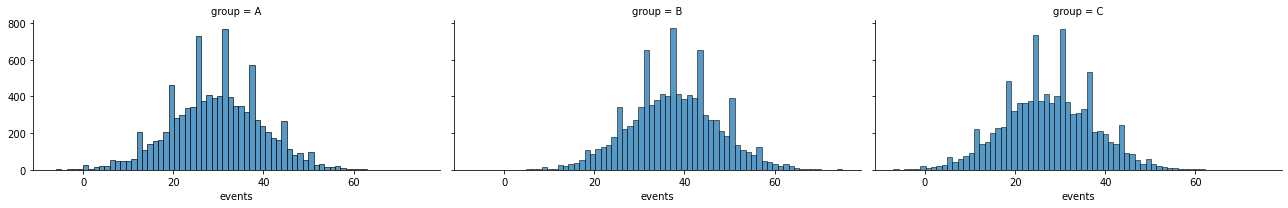

In [11]:
facet = sns.FacetGrid(experiment_1, col='group', aspect=2)
ax = facet.map(sns.histplot, 'events')

In [13]:
# Распределение во всех группах близко к нормальному

In [14]:
# Проведем ANOVA тест при помощи библиотеки scipy.stats
ss.f_oneway(a, b, c)

F_onewayResult(statistic=2886.166657438961, pvalue=0.0)

In [15]:
# Проведем ANOVA тест при помощи библиотеки statsmodel
model = smf.ols(formula = 'events ~ C(group)', data=experiment_1).fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
C(group),2.0,5.729361e+05,286468.062300,2886.166657,0.0
Residual,29997.0,2.977369e+06,99.255551,NaN,NaN


In [16]:
# Проведем ANOVA тест при помощи библиотеки pingouin
pg.anova(data=experiment_1, dv='events', between='group')

,Source,ddof1,ddof2,F,p-unc,np2
0,group,2,29997,2886.166657,0.0,0.161377


In [17]:
# Результаты обоих тестов выявили наличие значимых различий между группами

In [18]:
# Теперь проведем попарное сравнение групп при помощи критерия Тьюки
pairwise_tukeyhsd(experiment_1.events, experiment_1.group).summary()

group1,group2,meandiff,p-adj,lower,upper,reject
A,B,8.034,0.001,7.7038,8.3642,True
A,C,-2.1093,0.001,-2.4395,-1.7791,True
B,C,-10.1433,0.001,-10.4735,-9.8131,True


In [19]:
# Попробуем также обычный t-тест и поправки на множественное сравнение
pg.pairwise_ttests(data=experiment_1, dv='events', between='group')

/opt/tljh/user/lib/python3.7/site-packages/pingouin/bayesian.py:146: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,BF10,hedges
0,group,A,B,False,True,-57.011134,19998.0,two-sided,0.000000e+00,inf,-0.806229
1,group,A,C,False,True,14.886135,19998.0,two-sided,7.500262e-50,1.054e+46,0.210514
2,group,B,C,False,True,72.420220,19998.0,two-sided,0.000000e+00,inf,1.024138


In [20]:
# т-тест с поправкой Бонферони
pg.pairwise_ttests(data=experiment_1, dv='events', between='group', padjust='bonf')

/opt/tljh/user/lib/python3.7/site-packages/pingouin/bayesian.py:146: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,A,B,False,True,-57.011134,19998.0,two-sided,0.000000e+00,0.000000e+00,bonf,inf,-0.806229
1,group,A,C,False,True,14.886135,19998.0,two-sided,7.500262e-50,2.250078e-49,bonf,1.054e+46,0.210514
2,group,B,C,False,True,72.420220,19998.0,two-sided,0.000000e+00,0.000000e+00,bonf,inf,1.024138


In [21]:
# т-тест с поправкой Холма
pg.pairwise_ttests(data=experiment_1, dv='events', between='group', padjust='holm')

/opt/tljh/user/lib/python3.7/site-packages/pingouin/bayesian.py:146: RuntimeWarning: divide by zero encountered in double_scalars
  bf10 = 1 / ((1 + t**2 / df)**(-(df + 1) / 2) / integr)


,Contrast,A,B,Paired,Parametric,T,dof,alternative,p-unc,p-corr,p-adjust,BF10,hedges
0,group,A,B,False,True,-57.011134,19998.0,two-sided,0.000000e+00,0.000000e+00,holm,inf,-0.806229
1,group,A,C,False,True,14.886135,19998.0,two-sided,7.500262e-50,7.500262e-50,holm,1.054e+46,0.210514
2,group,B,C,False,True,72.420220,19998.0,two-sided,0.000000e+00,0.000000e+00,holm,inf,1.024138


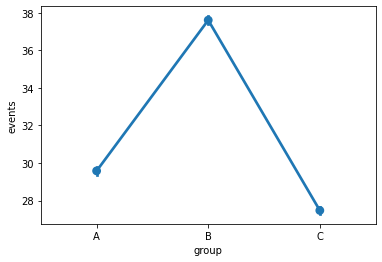

In [24]:
# В итоге, выбираем групппу B (квадратные картинки), так как у нее самое большое значение events и мы доказали, что
# эти различия значимы
sns.pointplot(data=experiment_1, x='group', y='events')

---

Во втором эксперименте требуется проверить, как пользователи отреагируют на изменение формата кнопки оформления заказа, с разбивкой по сегменту клиента.

In [25]:
experiment_2.head()

,id,group,segment,events
0,83440,test,high,78.0
1,96723,test,high,71.0
2,68719,test,high,80.0
3,50399,test,high,80.0
4,95613,test,high,78.0


In [ ]:
# В данном случае, будем использовать многофакторный дисперсионный анализ

In [27]:
test = experiment_2.query('group == "test"')
control = experiment_2.query('group == "control"')

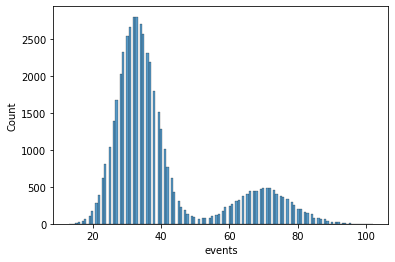

In [28]:
# Посмотрим на данные. Визуализируем распределение events для тестовой и контрольной группы
sns.histplot(test.events)

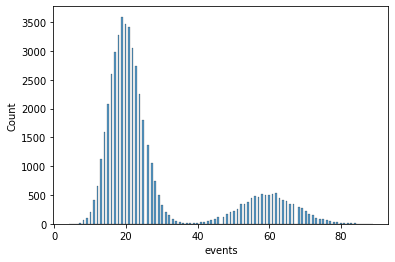

In [29]:
sns.histplot(control.events)

In [30]:
# Посчитаем среднее, медиану и стандартное отклонение events в разбивке по группе и по сегменту пользователя
experiment_2.groupby(['group', 'segment']).agg({'events': ['mean', 'median', 'std']})

events                 
                      mean median       std
group   segment                            
control high     59.970800   60.0  7.805347
        low      20.031575   20.0  4.473576
test    high     69.938500   70.0  8.403974
        low      33.025925   33.0  5.720845

In [33]:
# Проведем множественный дисперсионный анализ при помощи Statsmodels
model = smf.ols(data = experiment_2, formula='events ~ segment*group').fit()
anova_lm(model)

,df,sum_sq,mean_sq,F,PR(>F)
segment,1.0,2.362480e+07,2.362480e+07,689756.377484,0.000000e+00
group,1.0,3.837195e+06,3.837195e+06,112031.864119,0.000000e+00
segment:group,1.0,3.664244e+04,3.664244e+04,1069.823273,2.060261e-233
Residual,99996.0,3.424956e+06,3.425093e+01,NaN,NaN


In [43]:
# Тест позволяет предоположить значимые отличия между группами и взаимодействие факторов
# Теперь используем критерий Тьюки, чтобы понять между какими группами есть статистически значимые различия

In [42]:
# Создадаим колонку 'combination'
experiment_2['combination'] = experiment_2.group + ' / ' + experiment_2.segment
experiment_2.head()

,id,group,segment,events,combination
0,83440,test,high,78.0,test / high
1,96723,test,high,71.0,test / high
2,68719,test,high,80.0,test / high
3,50399,test,high,80.0,test / high
4,95613,test,high,78.0,test / high


In [44]:
MultiComparison(experiment_2.events, experiment_2.combination).tukeyhsd().summary()

group1,group2,meandiff,p-adj,lower,upper,reject
control / high,control / low,-39.9392,0.001,-40.1073,-39.7711,True
control / high,test / high,9.9677,0.001,9.7551,10.1803,True
control / high,test / low,-26.9449,0.001,-27.113,-26.7768,True
control / low,test / high,49.9069,0.001,49.7388,50.075,True
control / low,test / low,12.9944,0.001,12.888,13.1007,True
test / high,test / low,-36.9126,0.001,-37.0807,-36.7445,True


In [45]:
experiment_2.head()

,id,group,segment,events,combination
0,83440,test,high,78.0,test / high
1,96723,test,high,71.0,test / high
2,68719,test,high,80.0,test / high
3,50399,test,high,80.0,test / high
4,95613,test,high,78.0,test / high


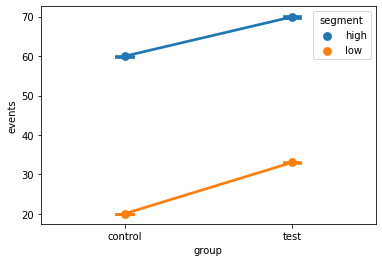

In [50]:
# Визуализируем результаты теста
sns.pointplot(data=experiment_2, x='group', y='events', hue='segment', capsize=0.1, order=['control', 'test'])

### Вывод: 
Фактор group оказался ЗНАЧИМЫМ, фактор segment – ЗНАЧИМЫМ, их взаимодействие – ЗНАЧИМО
Cудя по графику, для всех групп среднее значение events УВЕЛИЧИЛОСЬ, поэтому решение: ВЫКАТЫВАЕМ НОВУЮ ВЕРСИЮ